# Проект "Аналитическое исследование и разработка прогнозной модели рынка жилой недвижимости г. Москвы"

## Описание задачи

### Постановка задачи
**Целью** данного проекта является выявление ключевых ценообразующих факторов на рынке недвижимости Москвы и разработка математической модели для оценки рыночной стоимости объектов. 

**Бизнес-задачи:**
* Оптимизация процесса оценки объектов для внутреннего использования.
* Повышение прозрачности ценообразования для конечных клиентов через внедрение инструментов автоматизированного расчета.
* Определение степени влияния инфраструктурных факторов (близость к метро) и физических характеристик здания на ликвидность объекта.

### Описание проделанной работы

В данной работе была предпринята попытка обучения модели линейной регрессии с $L_1$-регуляризатором с целью предсказания рыночной стоимости недвижимости на основе её характеристик. После обучения было обнаружено, что ошибки в предсказаниях модели в среднем возрастали с ростом стоимости жилья, при этом на сравнительно недорогих объектах модель демонстрировала вполне приемлемое качество. В связи с этим было предпринято стратегическое решение разделить объекты условно на дорогие и недорогие и на полученных подвыборках обучить две новые модели.

В итоге для обученной на недорогих объектах недвижимости модели удалось достичь коэффициента детерминации $R^2 \approx 71,5\%$ и средней относительной ошибки $MAPE \approx 28,2\%$ со средней абсолютной ошибкой $MAE \approx 9,2$. Модель уловила основные признаки, влияющие на ценообразование московского рынка недвижимости, что позволяет в большинстве случаев получить среднюю рыночную стоимость объекта. На основе полученных весов модели была построена математическая модель — готовая формула для расчёта среднерыночной стоимости жилья.

В то же время модель, обученная на дорогих квартирах, не показала высоких результатов и, как и ожидалось, показала, что распределение ошибок не подчиняется нормальному закону, а значит, на её результаты полагаться не стоит. Для улучшения качества модели было порекомендовано провести дополнительный сбор данных об объектах недвижимости либо проведение экспертного расчёта в конкретных случаях.

### Описание используемых данных
Анализ проводится на основе предоставленного датасета, содержащего следующие атрибуты объектов:
*   `price` — цена объекта недвижимости в рублях (RUB).
*   `min_to_metro` — примерное время в минутах, необходимое для пешей прогулки от объекта до ближайшей станции метро.
*   `region_of_moscow` — административный округ Москвы, в котором расположен объект
*   `total_area` — общая площадь объекта в квадратных метрах.
*   `living_area` — жилая площадь объекта в квадратных метрах (площадь комнат).
*   `floor` — этаж, на котором расположена квартира в доме.
*   `number_of_floors` — общее количество этажей в доме, где находится объект.
*   `construction_year` — год постройки дома.
*   `is_new` — бинарный индикатор, указывающий, является ли объект новостройкой.
*   `is_apartments` — бинарный индикатор, указывающий, классифицируется ли объект как апартаменты (в апартаментах может быть нельзя зарегистрироваться по месту жительства).
*   `ceiling_height` — высота потолков в объекте, измеряется в метрах.
*   `number_of_rooms` — количество комнат в объекте (включая спальни, гостиные и другие).
*   `link` — URL-ссылка на оригинальное объявление об объекте для получения дополнительной информации.

In [1]:
# Импортируем требуемые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
%matplotlib inline

In [2]:
# Загрузим данные

try:
    estate = pd.read_csv('datasets/moscow_flats_dataset.csv')
except:
    print('Ошибка чтения файла!')

In [3]:
estate.head()

,price,min_to_metro,region_of_moscow,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms,link
0,31633073.0,24.0,ЮАО,64.2,32.4,11.0,16.0,2023.0,1.0,0.0,3.15,2.0,https://www.cian.ru/sale/flat/293204033/
1,29293000.0,9.0,СВАО,78.1,NaN,9.0,27.0,2022.0,1.0,0.0,NaN,2.0,https://www.cian.ru/sale/flat/294033524/
2,30349669.0,5.0,ЮАО,72.4,33.6,3.0,24.0,2023.0,1.0,0.0,3.15,2.0,https://www.cian.ru/sale/flat/300712697/
3,31845511.0,19.0,ЮАО,69.2,NaN,2.0,12.0,2024.0,1.0,0.0,2.97,2.0,https://www.cian.ru/sale/flat/300228448/
4,38810000.0,27.0,ЗАО,66.9,24.8,9.0,14.0,2023.0,1.0,0.0,3.00,2.0,https://www.cian.ru/sale/flat/299262105/


In [4]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6983 entries, 0 to 6982
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              6961 non-null   float64
 1   min_to_metro       6846 non-null   float64
 2   region_of_moscow   6892 non-null   object 
 3   total_area         6960 non-null   float64
 4   living_area        4514 non-null   float64
 5   floor              6960 non-null   float64
 6   number_of_floors   6960 non-null   float64
 7   construction_year  5761 non-null   float64
 8   is_new             6949 non-null   float64
 9   is_apartments      6949 non-null   float64
 10  ceiling_height     5053 non-null   float64
 11  number_of_rooms    6983 non-null   float64
 12  link               6983 non-null   object 
dtypes: float64(11), object(2)
memory usage: 709.3+ KB


Видим, что:
* поле `link` не потребуется для работы
* поле `region_of_moscow` содержит категориальные данные
* все поля, за исключением `number_of_rooms`, содержат пропуски

## Предобработка данных

Вначале займёмся обработкой пропущенных значений. Предварительно избавимся от поля `link`:

In [5]:
# Отбросим поле link

estate = estate.drop(columns = ['link'])

estate.head()

,price,min_to_metro,region_of_moscow,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms
0,31633073.0,24.0,ЮАО,64.2,32.4,11.0,16.0,2023.0,1.0,0.0,3.15,2.0
1,29293000.0,9.0,СВАО,78.1,NaN,9.0,27.0,2022.0,1.0,0.0,NaN,2.0
2,30349669.0,5.0,ЮАО,72.4,33.6,3.0,24.0,2023.0,1.0,0.0,3.15,2.0
3,31845511.0,19.0,ЮАО,69.2,NaN,2.0,12.0,2024.0,1.0,0.0,2.97,2.0
4,38810000.0,27.0,ЗАО,66.9,24.8,9.0,14.0,2023.0,1.0,0.0,3.00,2.0


### Обработка пропусков

Напишем функцию, которая покажет пропуски в абсолютном и относительном значениях:

In [6]:
# Создадим функцию для подсчёта пропусков

def display_na_info(ds):
    """
    Отображает информацию о пропусках в датасете в абсолютном и 
    относительном значениях.
    """
    if ds.isna().any().any(): # если хоть в одном столбце пропуск
        na_info = pd.DataFrame({
            'Количество пропусков': ds.isnull().sum(),
            '% пропусков': round(ds.isnull().mean() * 100, 2).astype(str) + '%'
        })
        na_info.index.name = 'Название поля'
        return na_info
        
    # Иначе пропусков нет
    print('Пропусков нет')

In [7]:
# Отобразим пропуски

display_na_info(estate)

,Количество пропусков,% пропусков
Название поля,,
price,22,0.32%
min_to_metro,137,1.96%
region_of_moscow,91,1.3%
total_area,23,0.33%
living_area,2469,35.36%
floor,23,0.33%
number_of_floors,23,0.33%
construction_year,1222,17.5%
is_new,34,0.49%


#### План обработки пропусков

Логично сделать предположение, что, в зависимости от района Москвы и новизны застройки, планировка недвижимостей разнится. По этой причине особенно важными полями для нас будут `region_of_moscow`, `is_new` и `construction_year`

Выпишем в таблицу действия над пропусками:

| Название колонки | Обоснование | Что делаем с пропусками |
|---|---|---|
| `price` | `price` целевая переменная. Возможны выбросы | **Заменим медианным значением по округу и новизне дома** |
| `min_to_metro` | В разных регионах путь до метро занимает разное время | **Заменим на среднее по региону** |
| `region_of_moscow` | Пропусков `1.3%` от всех данных, и это поле для нас существенно | **Записи с пропусками удалим** |
| `total_area` | Планировка недвижимости обычно похожа в зависимости от характеристик недвижимости и её района (*проверить корреляцию имеющихся данных по этому полю с характеристиками*) | Поле **заполним средним по району и характеристикам** (если наблюдается корреляция) |
| `living_area` | (см. решение для `total_area`) | **Заполним средним по району и году постройки** |
| `floor` | Люди склонны приобретать недвижимость не на крайних этажах. Для высоток в районах с сравнительно низкой средней высотой зданий могут присутствовать верхние этажи — для таких районов это скорее выбросы | **Заменим средним по району и полю `construction_year`** |
| `number_of_floors` | В разных районах в разное время строили дома разных этажностей | **Заменим средним по району и полю `construction_year`** |
| `construction_year` | Поле важное. Очевидна корреляция с полем `is_new` | **Заменим средним по району и полю `is_new`** |
| `is_new` | Пропусков по полю содержится `0.49%`; это поле для нас существенно, т. к. от новизны постройки зависит планировка | Часть пропусков **восстановим** по полю `construction_year`. **От остальных пропусков избавимся** |
| `is_apartments` | В многоквартирном доме могут находиться как апартаменты, так и квартиры. Знать об этом мы не можем. Пропусков `0.49%` от имеющихся данных | **Удалим** |
| `ceiling_height` | Как правило, высота потолков по району мало отличается от среднего. В зависимости от новизны застроки планировка также может меняться (*проверить корреляцию*) | **Заменим на среднее по району и полю `construction_year`** |
| `number_of_rooms` | *пропусков нет* | **—** |

Всюду, где происходит замена на медианное значение, потребуется изучение выбросов.

Пары полей `floor`, `number_of_floors` и `is_new`, `is_apartments` содержат одинаковое количество пропусков. Эти записи потребуется проверить на совпадение.

In [8]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6983 entries, 0 to 6982
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              6961 non-null   float64
 1   min_to_metro       6846 non-null   float64
 2   region_of_moscow   6892 non-null   object 
 3   total_area         6960 non-null   float64
 4   living_area        4514 non-null   float64
 5   floor              6960 non-null   float64
 6   number_of_floors   6960 non-null   float64
 7   construction_year  5761 non-null   float64
 8   is_new             6949 non-null   float64
 9   is_apartments      6949 non-null   float64
 10  ceiling_height     5053 non-null   float64
 11  number_of_rooms    6983 non-null   float64
dtypes: float64(11), object(1)
memory usage: 654.8+ KB


Определим, какие квартиры следует считать новостройками:

Самая старая новостройка — 2013 года рождения



<Axes: xlabel='construction_year', ylabel='is_new'>

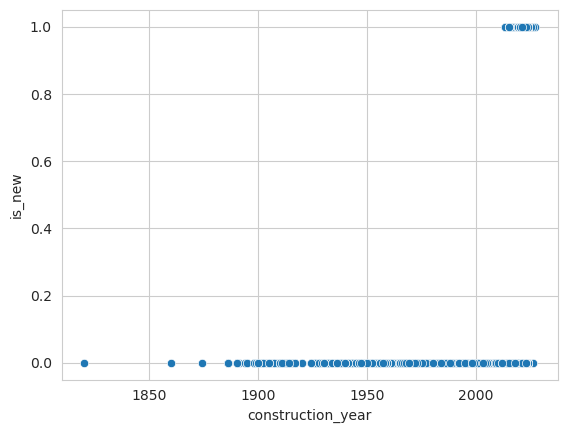

In [9]:
# Какие квартиры считаем новостройками

min_new_development_birthday = int( estate[estate['is_new'] == True]['construction_year'].min() )
print(f"Самая старая новостройка — {min_new_development_birthday} года рождения\n")

sns.scatterplot(data = estate, x = 'construction_year', y = 'is_new')

Видим, что имеются относительно (2013 года и старше) молодые застройки, не считающиеся новостройками. Это — не ошибка в данных: дело в том, что в сфере недвижимости термин «новостройка» (`is_new`) обычно означает не возраст здания, а *статус сделки*. Это означает, что недвижимости, для которых год постройки 2013 и больше, но они не считаются новостройками, являются вторичным жильём; аналогично новостройки от 2013 года и позже относятся к первичному жилью.

Стоимость новостроек, как правило, выше стоимости перепродаваемых квартир. Это необходимо будет учесть при обучении модели. Создадим бинарный признак, указывающий на то, является ли недвижимость вторичкой или нет:

In [10]:
# Создадим признак is_primary — индикатор первичного жилья

estate['is_primary'] = (
    (estate['construction_year'] >= min_new_development_birthday) & 
    (estate['is_new'] == True)
).astype(int)

estate.head()

Название поля,price,min_to_metro,region_of_moscow,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms,is_primary
0,31633073.0,24.0,ЮАО,64.2,32.4,11.0,16.0,2023.0,1.0,0.0,3.15,2.0,1
1,29293000.0,9.0,СВАО,78.1,NaN,9.0,27.0,2022.0,1.0,0.0,NaN,2.0,1
2,30349669.0,5.0,ЮАО,72.4,33.6,3.0,24.0,2023.0,1.0,0.0,3.15,2.0,1
3,31845511.0,19.0,ЮАО,69.2,NaN,2.0,12.0,2024.0,1.0,0.0,2.97,2.0,1
4,38810000.0,27.0,ЗАО,66.9,24.8,9.0,14.0,2023.0,1.0,0.0,3.00,2.0,1


В полях `is_new` и `is_apartments` одинаковое количество пропусков. Проверим, содержатся ли они в одних и тех же строках:

In [11]:
# Проверим, всем ли пропускам в поле is_new соответствуют пропуски из is_apartment

estate[estate['is_new'].isna() & estate['is_apartments'].isna()].shape[0] == estate[estate['is_new'].isna()].shape[0]

True

Это действительно так. Отбросим эти записи:

In [12]:
# Избавимся от пропусков в поле is_new (и is_apart)

estate.dropna(subset = ['is_new'], inplace = True)

display_na_info(estate)

,Количество пропусков,% пропусков
Название поля,,
price,0,0.0%
min_to_metro,112,1.61%
region_of_moscow,68,0.98%
total_area,0,0.0%
living_area,2444,35.17%
floor,0,0.0%
number_of_floors,0,0.0%
construction_year,1196,17.21%
is_new,0,0.0%


Нам удалось избавиться от большего количества пропусков.

In [13]:
# Удалим пропуски в поле region_of_moscow и
# преобразуем поле к категориальному типу

estate.dropna(subset = ['region_of_moscow'], inplace = True)
estate['region_of_moscow'] = estate['region_of_moscow'].astype('category')

display_na_info(estate)

,Количество пропусков,% пропусков
Название поля,,
price,0,0.0%
min_to_metro,112,1.63%
region_of_moscow,0,0.0%
total_area,0,0.0%
living_area,2420,35.17%
floor,0,0.0%
number_of_floors,0,0.0%
construction_year,1187,17.25%
is_new,0,0.0%


In [14]:
# Выведем результат преобразования

estate['region_of_moscow'].unique()

['ЮАО', 'СВАО', 'ЗАО', 'ЦАО', 'ЮЗАО', 'ВАО', 'ЮВАО', 'СЗАО', 'САО']
Categories (9, object): ['ВАО', 'ЗАО', 'САО', 'СВАО', ..., 'ЦАО', 'ЮАО', 'ЮВАО', 'ЮЗАО']

Согласно намеченному выше плану, оставшиеся поля будем заполнять средними значениями по группам. Для этого создадим шаблон:

In [15]:
# Создадим функцию для заполнения поля target аггрегированным значением

def fill_with_aggregated_value(df, target, by_list, agg = 'mean'):
    """
    Заполняет поле target аггрегированным по полям из by_list значением
    """
    
    df.loc[:, target] = df[target].fillna(
        df.groupby(by = by_list, observed = False)[target].transform(agg)
    )
    
    print(f"Осталось {estate[target].isna().sum()} пропусков 👌")
    return df

Заполним оставшиеся поля.

In [16]:
# Заполним пропуски в поле min_to_metro средним по региону

estate = fill_with_aggregated_value(estate, 'min_to_metro', ['region_of_moscow'])

Осталось 0 пропусков 👌


In [17]:
# Заполним пропуски в поле min_to_metro средним по региону и типу жилья

estate = fill_with_aggregated_value(estate, 'construction_year', ['region_of_moscow', 'is_new'])

Осталось 0 пропусков 👌


In [18]:
# Заполним пропуски в поле min_to_metro средним по региону и году постройки

estate = fill_with_aggregated_value(estate, 'living_area', ['region_of_moscow', 'construction_year'])

Осталось 50 пропусков 👌


Для оставшихся 50 строк среднее не получилось вычислить. Попробуем вычислить среднее по региону и типу застройки:

In [19]:
# Заполним пропуски в поле min_to_metro средним по региону и типу жилья

estate = fill_with_aggregated_value(estate, 'living_area', ['region_of_moscow', 'is_new'])

Осталось 0 пропусков 👌


In [20]:
# Заполним пропуски в поле min_to_metro средним по региону и году постройки

estate = fill_with_aggregated_value(estate, 'ceiling_height', ['region_of_moscow', 'construction_year'])

Осталось 27 пропусков 👌


Аналогично вычислим среднее по региону и полю `is_new`:

In [21]:
# Заполним пропуски в поле min_to_metro средним по региону и типу жилья

estate = fill_with_aggregated_value(estate, 'ceiling_height', ['region_of_moscow', 'is_new'])

Осталось 0 пропусков 👌


Проверим наличие пропусков:

In [22]:
display_na_info(estate)

Пропусков нет


От пропусков мы избавились

### Преобразование к подходящим типам

Посмотрим ещё раз на информацио о наборе данных:

In [23]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6881 entries, 0 to 6982
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   price              6881 non-null   float64 
 1   min_to_metro       6881 non-null   float64 
 2   region_of_moscow   6881 non-null   category
 3   total_area         6881 non-null   float64 
 4   living_area        6881 non-null   float64 
 5   floor              6881 non-null   float64 
 6   number_of_floors   6881 non-null   float64 
 7   construction_year  6881 non-null   float64 
 8   is_new             6881 non-null   float64 
 9   is_apartments      6881 non-null   float64 
 10  ceiling_height     6881 non-null   float64 
 11  number_of_rooms    6881 non-null   float64 
 12  is_primary         6881 non-null   int64   
dtypes: category(1), float64(11), int64(1)
memory usage: 705.9 KB


#### Преобразование поля `floor`

Выясним, все ли этажи указаны корректно:

In [24]:
# Выясним, есть ли дробные этажи

(estate['floor'].value_counts() % 1 == 0).all()

np.True_

Преобразуем их к целочисленному типу:

In [25]:
# Преобразуем этажи к целочисленному типу

estate['floor'] = pd.to_numeric(estate['floor'], downcast = 'integer')

#### Преобразование полей `number_of_floors`, `construction_year`, `is_new`, `is_apartments`

Поля `number_of_floors`, `construction_year`, `is_new`, `is_apartments` также преобразуем к целочисленному типу:

In [26]:
# Преобразуем указанные поля к целочисленному типу

# Отдельно преобразуем construction_year
estate['construction_year'] = estate['construction_year'].astype(int)

for col in ['number_of_floors', 'construction_year', 'is_new', 'is_apartments']:
    estate[col] = pd.to_numeric(estate[col], downcast = 'integer')

In [27]:
estate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6881 entries, 0 to 6982
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   price              6881 non-null   float64 
 1   min_to_metro       6881 non-null   float64 
 2   region_of_moscow   6881 non-null   category
 3   total_area         6881 non-null   float64 
 4   living_area        6881 non-null   float64 
 5   floor              6881 non-null   int8    
 6   number_of_floors   6881 non-null   int8    
 7   construction_year  6881 non-null   int16   
 8   is_new             6881 non-null   int8    
 9   is_apartments      6881 non-null   int8    
 10  ceiling_height     6881 non-null   float64 
 11  number_of_rooms    6881 non-null   float64 
 12  is_primary         6881 non-null   int64   
dtypes: category(1), float64(6), int16(1), int64(1), int8(4)
memory usage: 477.5 KB


### Анализ и обработка выбросов

Рассмотрим статистики набора данных:

In [28]:
estate.describe()

Название поля,price,min_to_metro,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms,is_primary
count,6.881000e+03,6881.000000,6881.000000,6881.000000,6881.000000,6881.000000,6881.000000,6881.000000,6881.000000,6881.000000,6881.000000,6881.000000
mean,6.028813e+07,13.271695,84.450510,47.887895,10.537858,19.548757,2001.500509,0.266095,0.156809,3.070862,2.488882,0.266095
std,9.398653e+07,76.982546,51.956283,28.839427,10.669441,14.489952,26.400125,0.441947,0.363647,0.632103,1.082726,0.441947
min,8.000000e+05,1.000000,9.000000,1.000000,-1.000000,1.000000,1820.000000,0.000000,0.000000,2.000000,1.000000,0.000000
25%,1.657582e+07,6.000000,45.000000,27.700000,4.000000,9.000000,1987.000000,0.000000,0.000000,2.800000,2.000000,0.000000
50%,3.070730e+07,9.883178,71.000000,41.250000,7.000000,16.000000,2012.000000,0.000000,0.000000,3.013171,2.000000,0.000000
75%,6.340000e+07,14.000000,106.700000,63.700000,14.000000,25.000000,2023.000000,1.000000,0.000000,3.200000,3.000000,1.000000
max,3.737636e+09,2025.000000,530.000000,350.000000,80.000000,95.000000,2027.000000,1.000000,1.000000,30.000000,4.000000,1.000000


Сразу видно:
* имеется как минимум одна квартира с явно высокой — по сравнению со средним значением — стоимостью
* в какой-то записи указано 2025 минут до метро. Вряд ли 34-часовой поход до ближайшего метро привлечёт покупателей. Скорее всего, это ошибка в заполнении данных
* в Москве есть дворец площадью 530 кв. метров
* в Москве есть квартира площадью 9 кв. метров
* минимальная жилая площадь по Москве 1 кв. метр
* в Москве есть новостройки, построенные в будущем — в 2027 году
* ранее мы видели, что имеются крайне старые квартиры — существовавшие ещё в XIX веке
* в некоторой квартире высота потолков достигает 30 метров

Обработаем выбросы в каждом из этих полей.

#### Выбросы в поле `price`

`price` —  целевая переменная. Посмотрим на распределение стоимостей:

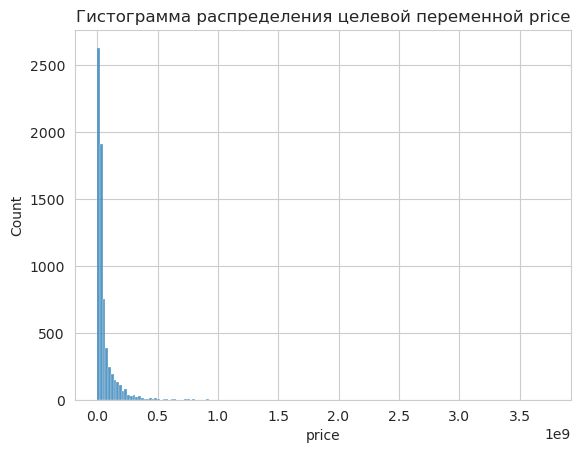

In [29]:
# Рассмотрим гистограмму целевой переменной

sns.histplot(data = estate, x = 'price')
plt.title('Гистограмма распределения целевой переменной price')
plt.show()

Полезно также будет взглянуть на выбросы нашей переменной:

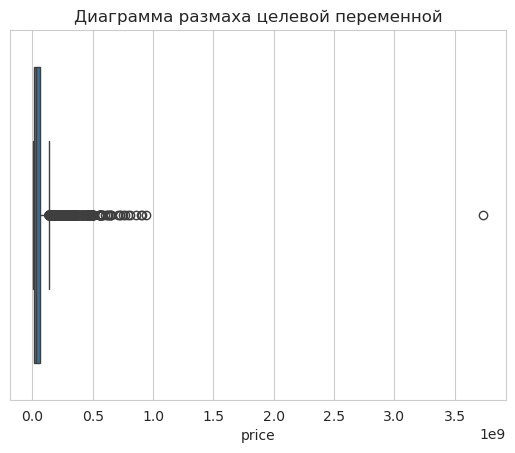

In [30]:
# Рассмотрим ящик с усами для целевой переменной

sns.boxplot(data = estate, x = 'price')
plt.title('Диаграмма размаха целевой переменной')
plt.show()

Видим длинный хвост справа. Чтобы от него избавиться, отлогарифмируем шкалу:

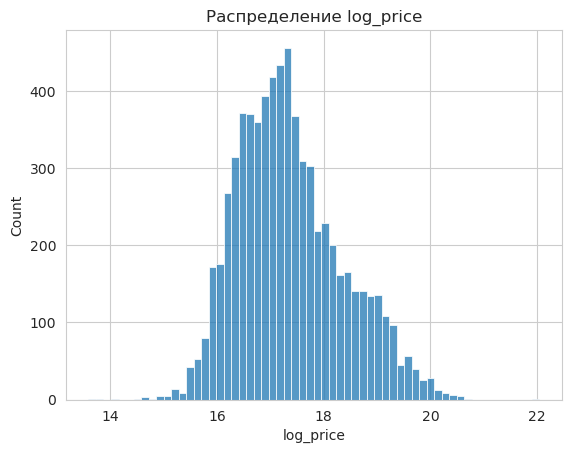

In [31]:
# Создадим переменную log_price — логарифмированную целевую переменную
estate['log_price'] = np.log(estate['price'])

sns.histplot(data = estate, x = 'log_price')
plt.title('Распределение log_price')
plt.show()

#### Выбросы в поле `min_to_metro`

Поищем выбросы в поле `min_to_metro`:

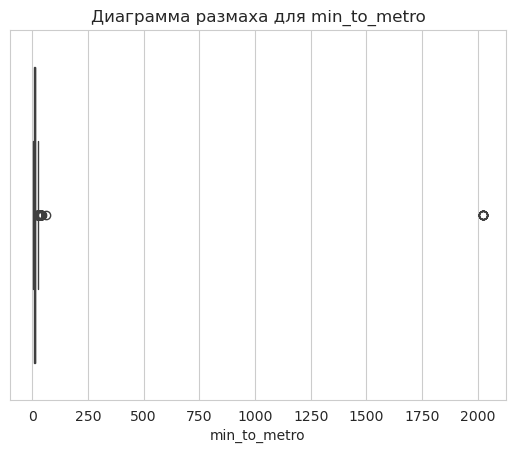

In [32]:
# Рассмотрим усиковую диаграмму для признака min_to_metro

sns.boxplot(data = estate, x = 'min_to_metro')
plt.title('Диаграмма размаха для min_to_metro')
plt.show()

Найдём записи с таким количеством минут:

In [33]:
# Вычленим данные с выбросами

unreal_min_to_metro = estate.loc[estate['min_to_metro'] == estate['min_to_metro'].max()]
unreal_min_to_metro.head()

Название поля,price,min_to_metro,region_of_moscow,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms,is_primary,log_price
155,32923968.0,2025.0,СЗАО,70.4,35.7,19,29,2023,1,0,3.15,2.0,1,17.309711
212,30553120.0,2025.0,СЗАО,48.1,25.3,8,29,2023,1,0,3.15,2.0,1,17.234977
271,34371540.0,2025.0,СЗАО,56.7,29.4,14,29,2023,1,0,3.15,2.0,1,17.352739
500,38945280.0,2025.0,СЗАО,70.4,35.7,22,29,2023,1,0,3.15,2.0,1,17.477668
613,31324200.0,2025.0,СЗАО,49.8,25.2,6,29,2023,1,0,3.15,2.0,1,17.259902


Очевидно, перед нами ошибка заполнения данных. Глядя на данные, выявить причины, почему так произошло, не представляется возможным, поэтому от данных строк мы избавимся:

In [34]:
# Избавимся от выбросов по полю min_to_metro

estate.drop(unreal_min_to_metro.index, inplace = True)

Ещё раз рассмотрим ящик с усами для min_to_metro:

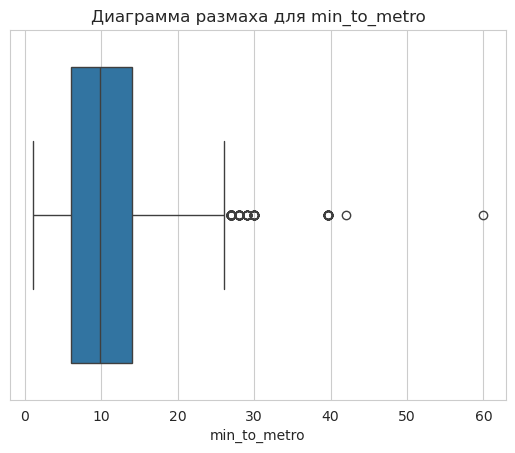

In [35]:
# Снова рассмотрим ящик с усами для min_to_metro

sns.boxplot(data = estate, x = 'min_to_metro')
plt.title('Диаграмма размаха для min_to_metro')
plt.show()

Отфильтруем значения, выбивающиеся за границы межквартильного размаха.

In [36]:
# Создадим функцию для расчёта межквартильного размаха и его границ

def IQR(field, coef = 1.5):
    """
    Рассчитывает межквартильный размах для поля field
    """
    
    # Рассчитаем квартили
    q1 = field.quantile(0.25)
    q3 = field.quantile(0.75)
    
    # Вычислим межквартильный размах
    iqr = q3 - q1

    # Вычислим границы
    left_border = q1 - coef * iqr
    right_border = q3 + coef * iqr
    
    return left_border, right_border, iqr

In [37]:
# Используем межквартильный размах для отсечения выбросов

# Вычислим правый ус для min_to_metro
left_border, min_to_metro_threshold, iqr = IQR(estate['min_to_metro'])

# Всё, что больше данного значения, не будем считать пешей прогулкой
estate = estate.loc[estate['min_to_metro'] <= min_to_metro_threshold]

estate['min_to_metro'].describe()

count    6719.000000
mean        9.892022
std         5.138724
min         1.000000
25%         6.000000
50%         9.000000
75%        13.000000
max        26.000000
Name: min_to_metro, dtype: float64

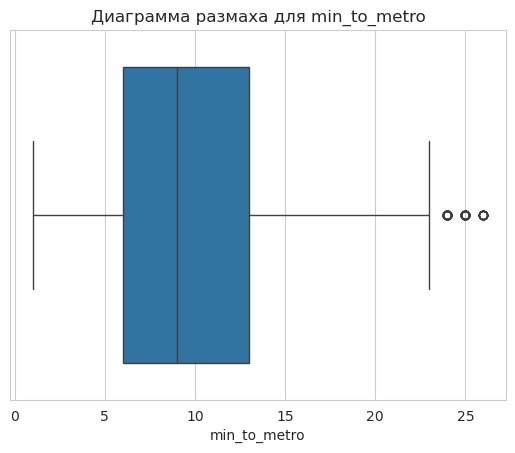

In [38]:
# Снова рассмотрим ящик с усами для min_to_metro

sns.boxplot(data = estate, x = 'min_to_metro')
plt.title('Диаграмма размаха для min_to_metro')
plt.show()

#### Выбросы в полях `total_area` и `living_area`

Поля `total_area` и `living_area` похожи по своей структуре, поэтому обрабатывать их будем синхронно:

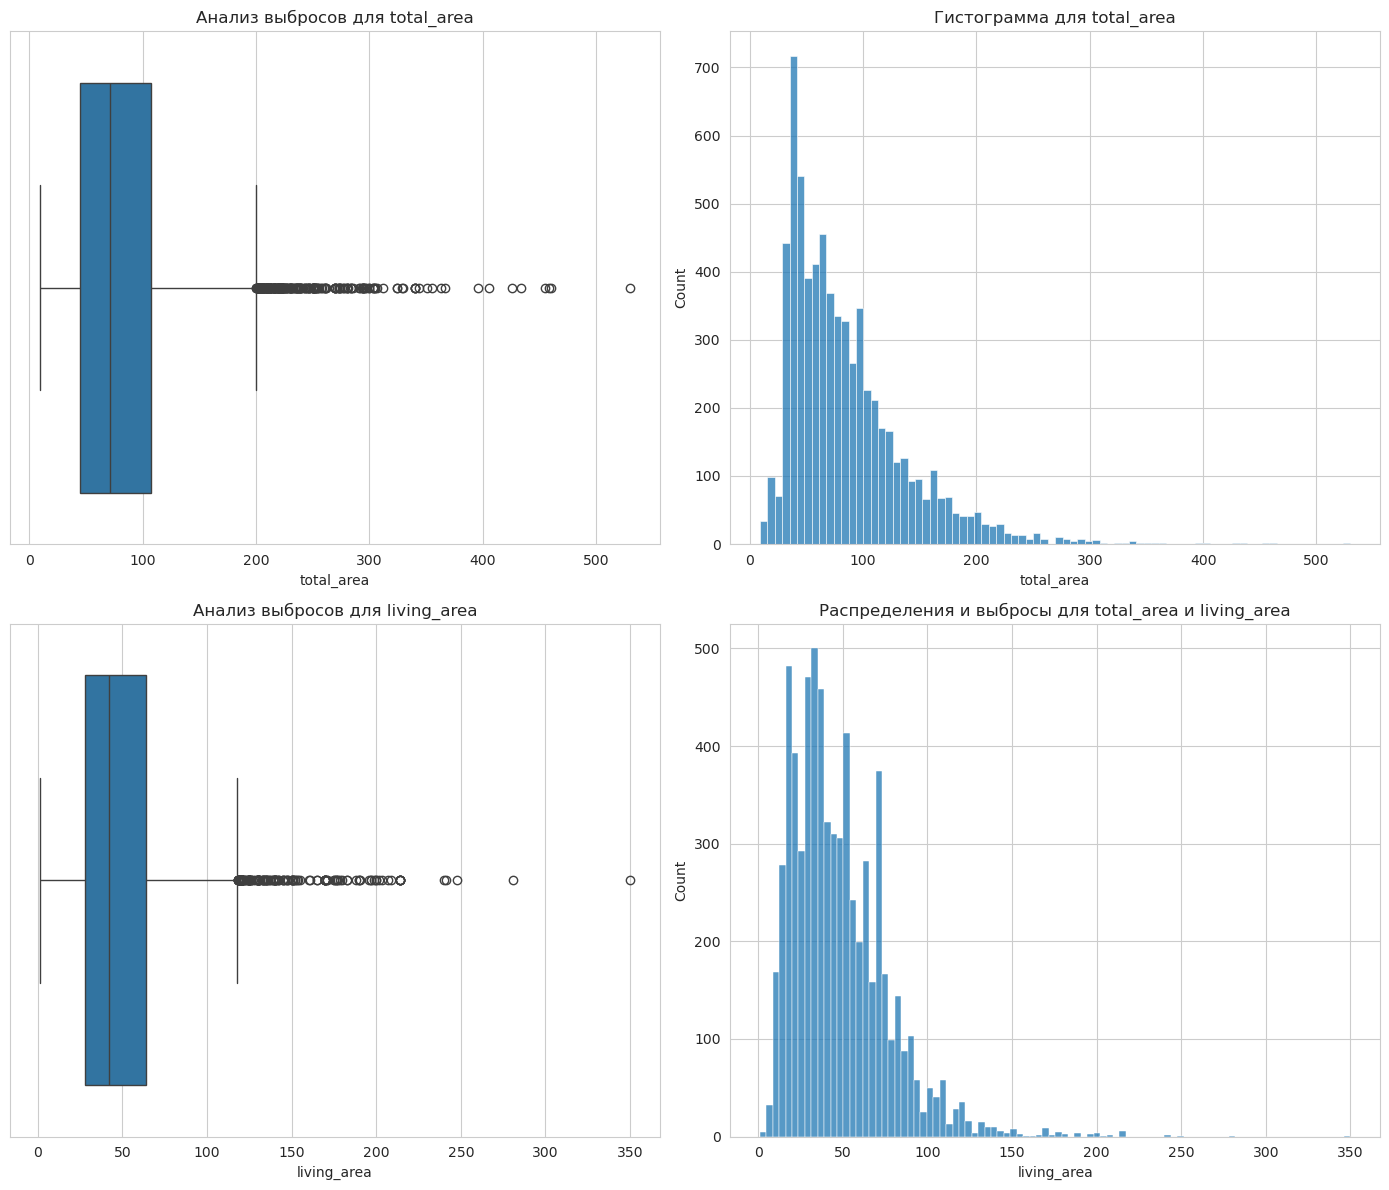

In [39]:
# Рассмотрим распределения и выбросы для total_area и living_area

fig, axes = plt.subplots(2, 2, figsize = (14, 12))

sns.boxplot(data = estate, x = 'total_area', ax = axes[0][0])
sns.histplot(data = estate, x = 'total_area', ax = axes[0][1])
sns.boxplot(data = estate, x = 'living_area', ax = axes[1][0])
sns.histplot(data = estate, x = 'living_area', ax = axes[1][1])

axes[0][0].set_title('Анализ выбросов для total_area')
axes[0][1].set_title('Гистограмма для total_area')
axes[1][0].set_title('Анализ выбросов для living_area')
axes[1][1].set_title('Гистограмма для living_area')

plt.tight_layout()
plt.title('Распределения и выбросы для total_area и living_area')
plt.show()

In [40]:
from scipy.stats import zscore

In [41]:
# Отлогарифмируем поля total_area и living_area

estate.loc[:, 'log_total_area'] = np.log(estate['total_area'])
estate.loc[:, 'log_living_area'] = np.log(estate['living_area'])

Отсечём те значения `log(total_area)` и `log(living_area)`, для которых $Z$-оценка больше $3$:

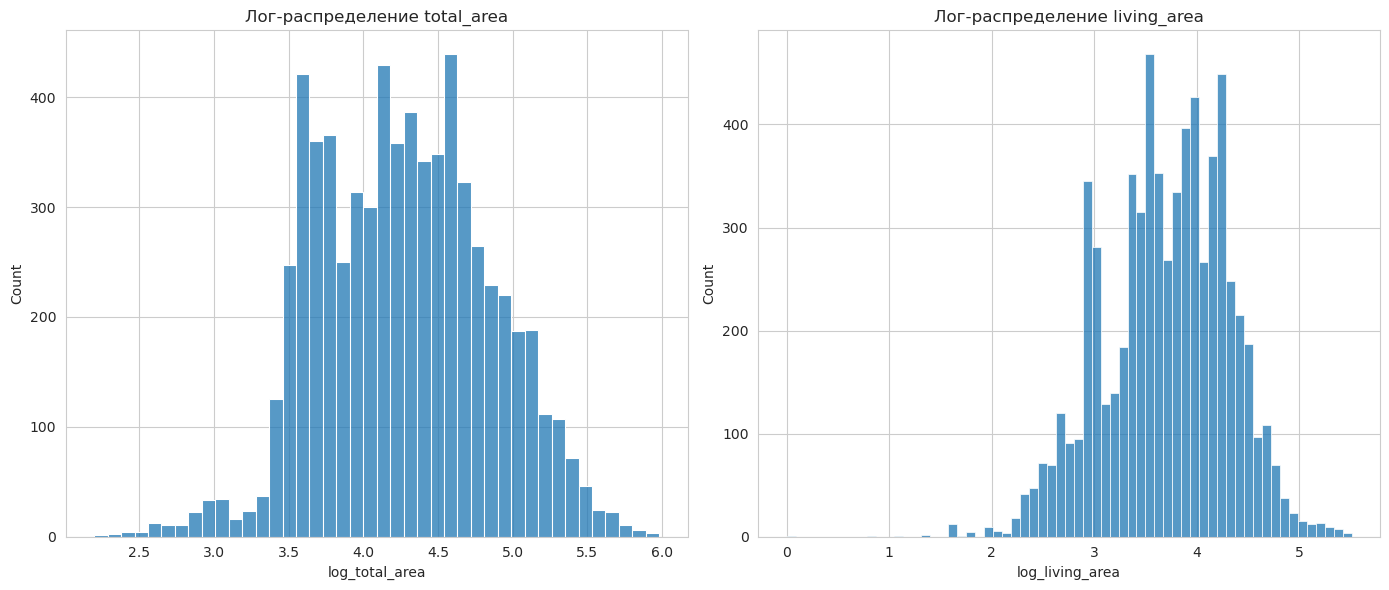

In [42]:
# Применим Z-оценку для фильтрации

estate = estate.loc[zscore(estate['log_total_area']) <= 3]
estate = estate.loc[zscore(estate['log_living_area']) <= 3]

fig, axes = plt.subplots(1, 2, figsize = (14, 6))

sns.histplot(data = estate, x = 'log_total_area',  ax = axes[0])
sns.histplot(data = estate, x = 'log_living_area', ax = axes[1])

axes[0].set_title('Лог-распределение total_area')
axes[1].set_title('Лог-распределение living_area')

plt.tight_layout()
plt.show()

Не лишним будет взглянуть на диаграмму рассеяния для этих полей.

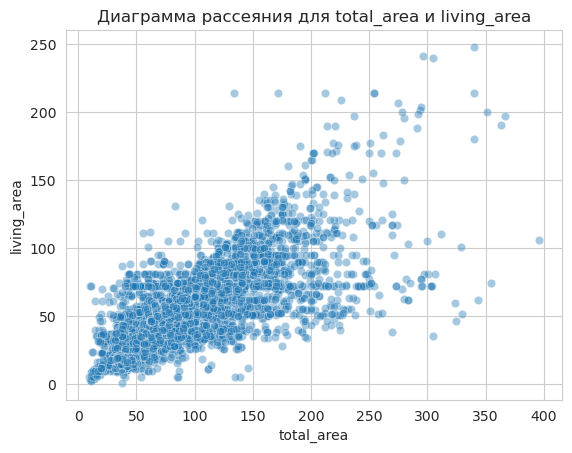

In [43]:
# Рассмотрим диаграмму рассеяния для total_area и living_area

sns.scatterplot(data = estate, x = 'total_area', y = 'living_area', alpha = 0.4)
plt.title('Диаграмма рассеяния для total_area и living_area')
plt.show()

In [44]:
# Найдём квартиры с некорректными площадями

swapped_areas_filter = estate['living_area'] >= estate['total_area']
swapped_areas = estate.loc[swapped_areas_filter].copy()
swapped_areas.head()

Название поля,price,min_to_metro,region_of_moscow,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms,is_primary,log_price,log_total_area,log_living_area
75,14924263.0,10.0,ЗАО,49.8,50.058730,11,25,2021,1,0,2.630000,2.0,1,16.518499,3.908015,3.913197
128,21286313.0,12.0,ЗАО,49.8,51.105263,10,21,2020,1,1,3.300000,2.0,1,16.873575,3.908015,3.933887
216,29060395.0,4.0,ЦАО,42.5,55.250000,19,22,2022,1,0,3.250000,2.0,1,17.184887,3.749504,4.011868
305,85974000.0,1.0,ЦАО,62.3,80.945098,8,9,2023,1,1,3.153488,2.0,1,18.269555,4.131961,4.393771
393,44999000.0,9.0,ЦАО,50.0,50.787500,1,6,2020,1,1,3.674815,2.0,1,17.622151,3.912023,3.927650


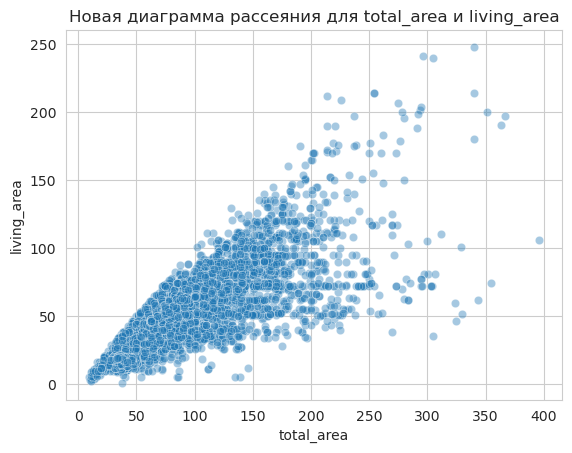

In [45]:
# Заменим некорректные площади местами

estate.loc[swapped_areas_filter, 'total_area'] = estate.loc[swapped_areas_filter, 'living_area']
estate.loc[swapped_areas_filter, 'living_area'] = swapped_areas['total_area']

sns.scatterplot(data = estate, x = 'total_area', y = 'living_area', alpha = 0.4)
plt.title('Новая диаграмма рассеяния для total_area и living_area')
plt.show()

In [46]:
estate['total_area'].describe()

count    6711.000000
mean       84.807497
std        50.411364
min         9.000000
25%        46.010000
50%        72.460648
75%       107.000000
max       396.270000
Name: total_area, dtype: float64

In [47]:
estate['living_area'].describe()

count    6711.000000
mean       47.338705
std        28.262751
min         1.000000
25%        27.150000
50%        40.500000
75%        62.084615
max       248.000000
Name: living_area, dtype: float64

#### Выбросы в поле `floor`

In [48]:
# Найдём квартиры на цокольном этаже

estate[estate['floor'] == -1]

Название поля,price,min_to_metro,region_of_moscow,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms,is_primary,log_price,log_total_area,log_living_area
3120,5900000.0,12.0,ВАО,30.0,21.0,-1,7,1980,0,1,3.058947,1.0,0,15.590463,3.401197,3.044522


Таких записей — одна. Во избежание переобучения от данной записи мы избавимся:

In [49]:
# Отбросим эту квартиру

estate = estate.loc[estate['floor'] != -1]

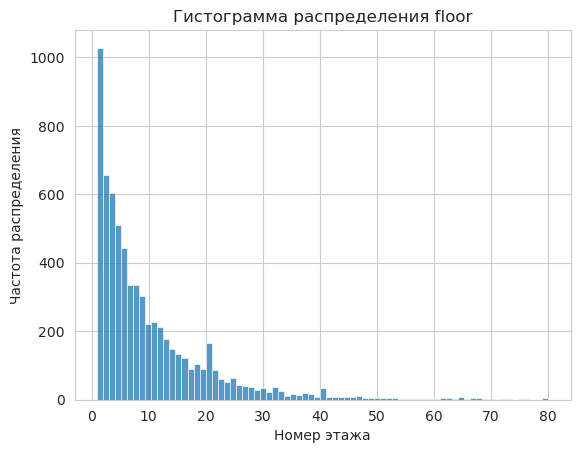

In [50]:
# Изобразим гистограмму распределения floor

sns.histplot(estate['floor'])
plt.title('Гистограмма распределения floor')
plt.xlabel('Номер этажа')
plt.ylabel('Частота распределения')
plt.show()

#### Выбросы в поле `number_of_floors`

Выясним, встрчались ли квартиры на этаже большем, чем количество этажей в доме:

In [51]:
# Найдём логические выбросы

(estate['floor'] > estate['number_of_floors']).any()

np.False_

In [52]:
# Найдём дробные значения

(estate['number_of_floors'] % 1 == 0).all()

np.True_

In [53]:
# Преобразуем number_of_floors к целочисленному типу

estate['number_of_floors'] = pd.to_numeric(estate['number_of_floors'], downcast = 'integer')

#### Выбросы в поле `ceiling_height`

In [54]:
# Как часто люди покупают тридцатиметровые по высоте квартиры

estate['ceiling_height'].value_counts().sort_index(ascending = False)

ceiling_height
30.000000      1
26.400000      1
23.000000      1
8.000000       1
7.000000       2
            ... 
2.535312       1
2.530000       1
2.500000     108
2.480000      29
2.000000       1
Name: count, Length: 309, dtype: int64

Видим, что явно выделяются значения 23, 26 и 30. Такая высота потолков в реальности вряд ли достижима, и, кроме того, она исказит модель; избавимся от этих записей:

In [55]:
# Отсеиваем выбросы по полю ceiling_height

MAX_CEILING_HEIGHT = 10
estate = estate.loc[estate['ceiling_height'] < MAX_CEILING_HEIGHT]

estate['ceiling_height'].value_counts().sort_index(ascending = False)

ceiling_height
8.000000      1
7.000000      2
6.900000      1
6.800000      1
6.500000      3
           ... 
2.535312      1
2.530000      1
2.500000    108
2.480000     29
2.000000      1
Name: count, Length: 306, dtype: int64

In [56]:
estate.describe()

Название поля,price,min_to_metro,total_area,living_area,floor,number_of_floors,construction_year,is_new,is_apartments,ceiling_height,number_of_rooms,is_primary,log_price,log_total_area,log_living_area
count,6.707000e+03,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000,6707.000000
mean,5.967564e+07,9.894065,84.833564,47.355055,10.410168,19.454003,2001.045177,0.253168,0.159535,3.062551,2.492769,0.253168,17.355272,4.269127,3.700343
std,8.191088e+07,5.140595,50.414513,28.262907,10.600074,14.524353,26.545667,0.434859,0.366201,0.399075,1.083895,0.434859,0.990967,0.573828,0.605109
min,8.000000e+05,1.000000,9.000000,1.000000,1.000000,1.000000,1820.000000,0.000000,0.000000,2.000000,1.000000,0.000000,13.592367,2.197225,0.000000
25%,1.647650e+07,6.000000,46.100000,27.200000,3.000000,9.000000,1987.000000,0.000000,0.000000,2.800000,2.000000,0.000000,16.617446,3.806662,3.332205
50%,3.060000e+07,9.000000,72.460648,40.500000,7.000000,16.000000,2010.000000,0.000000,0.000000,3.013171,2.000000,0.000000,17.236511,4.262680,3.734832
75%,6.372000e+07,13.000000,107.000000,62.084615,13.000000,25.000000,2022.000000,1.000000,0.000000,3.200000,3.000000,1.000000,17.970008,4.671519,4.158883
max,9.409220e+08,26.000000,396.270000,248.000000,80.000000,95.000000,2027.000000,1.000000,1.000000,8.000000,4.000000,1.000000,20.662371,5.982096,5.513429


## Исследовательский анализ данных

Выведем сётку графиков. Попутно выделим новостройки, чтобы попытаться уловить закономерность.

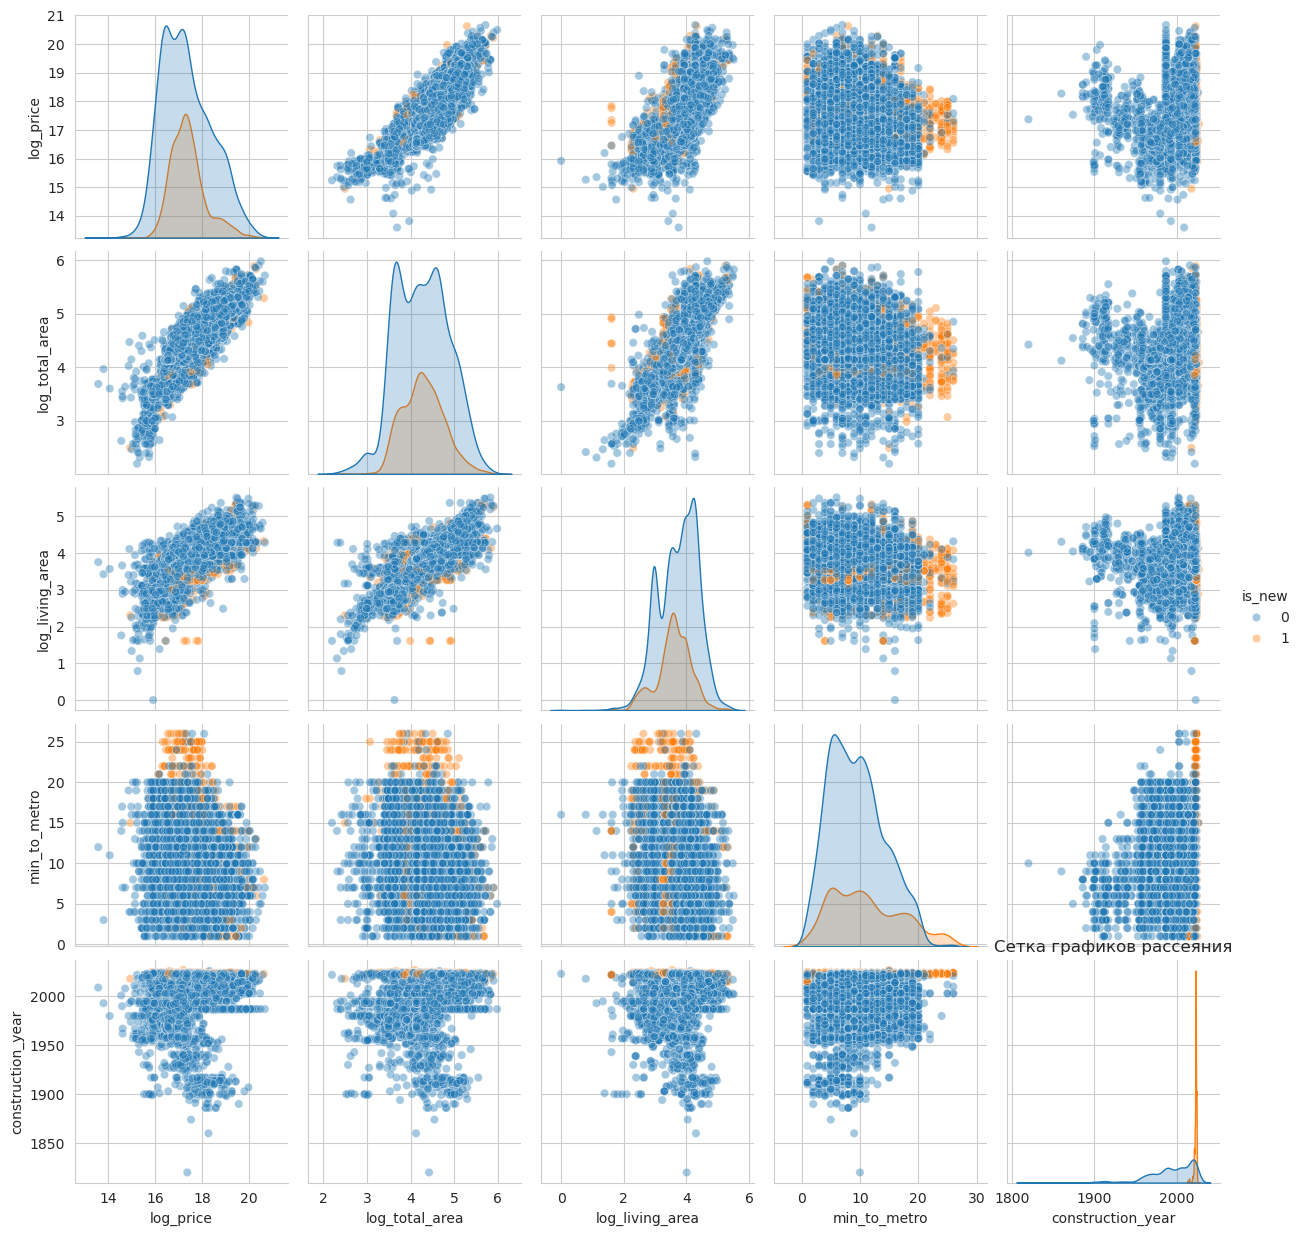

In [57]:
# Выведем сетку графиков

to_compare = ['log_price', 'log_total_area', 'log_living_area', 'min_to_metro', 'construction_year']

sns.pairplot(
    data = estate[to_compare + ['is_new']],
    hue = 'is_new',
    diag_kind = 'kde',
    plot_kws = {'alpha': 0.4}
)
plt.title('Сетка графиков рассеяния')
plt.show()

Видим и без графика очевидную сильную корреляцию `log_total_area` и `log_living_area`:

In [58]:
# Посчитаем корреляцию для log_total_area и log_living_area

estate['log_living_area'].corr(estate['log_total_area'])

np.float64(0.8121691667538208)

Также проглядывается зависимость стоимости от площади. Что касается графиков плотности ядра, то для `log_total_area` и `log_living_area` явно различимы два горба. Это означает, что в данных имеется скрытая зависимость, которую ещё предстоит выявить. Для поля `construction_year` выделяется пиковое значение — в этот год было сдано крайне высокое количество новостроек.

## Построение признаков

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
# Разделим признаки по категориям и соберём обучающую выборку

categorical_features = ['region_of_moscow']
binary_features = ['is_new', 'is_apartments', 'is_primary']
numeric_features = [
    'min_to_metro', 'floor', 
    'number_of_floors', 'construction_year', 
    'ceiling_height', 'number_of_rooms', 
    'log_total_area', 'log_living_area'
]
features = categorical_features + binary_features + numeric_features

# Выделим целевую переменную
y_col = 'log_price'

# Соберём обучющую выборку
log_y = estate[y_col]
X = estate[features]

X.head()

Название поля,region_of_moscow,is_new,is_apartments,is_primary,min_to_metro,floor,number_of_floors,construction_year,ceiling_height,number_of_rooms,log_total_area,log_living_area
0,ЮАО,1,0,1,24.0,11,16,2023,3.150,2.0,4.162003,3.478158
1,СВАО,1,0,1,9.0,9,27,2022,4.032,2.0,4.357990,3.966432
2,ЮАО,1,0,1,5.0,3,24,2023,3.150,2.0,4.282206,3.514526
3,ЮАО,1,0,1,19.0,2,12,2024,2.970,2.0,4.237001,3.587400
5,ЦАО,1,1,1,8.0,6,7,2016,3.250,2.0,4.647271,4.348433


In [61]:
# Разделим данные обучающие и тестовые

X_train_raw, X_test_raw, log_y_train, log_y_test = train_test_split(
    X, log_y,
    test_size = 0.2,
    random_state = 123,
    stratify = X['region_of_moscow']
)

In [62]:
# Импортиируем библиотеки для стандартизации и кодирования переменных

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [63]:
# Создадим трансформер для преобразования данных

transformer = ColumnTransformer(
    transformers = [
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown = 'ignore', drop = 'first', dtype = int), categorical_features),
        ('binary', 'passthrough', binary_features)
    ],
    verbose_feature_names_out = False
)

In [64]:
# Преобразуем данные

X_train = transformer.fit_transform(X_train_raw) # обучаем трансформер на X_train и преобразуем
X_test = transformer.transform(X_test_raw) # преобразуем X_test БЕЗ обучения

new_columns = transformer.get_feature_names_out() # возвращаем названия колонок

new_columns

array(['min_to_metro', 'floor', 'number_of_floors', 'construction_year',
       'ceiling_height', 'number_of_rooms', 'log_total_area',
       'log_living_area', 'region_of_moscow_ЗАО', 'region_of_moscow_САО',
       'region_of_moscow_СВАО', 'region_of_moscow_СЗАО',
       'region_of_moscow_ЦАО', 'region_of_moscow_ЮАО',
       'region_of_moscow_ЮВАО', 'region_of_moscow_ЮЗАО', 'is_new',
       'is_apartments', 'is_primary'], dtype=object)

## Обучение модели

In [65]:
# Импортируем регрессор с L1-регуляризацией

from sklearn.linear_model import LassoCV

In [66]:
# Обучим модель

lasso = LassoCV(cv = 5)
lasso.fit(X_train, log_y_train)
print('Ok 👌')

Ok 👌


In [67]:
# Предскажем значения

log_y_pred = lasso.predict(X_test)

In [68]:
# Посчитаем количество влияющих признаков

n_features = sum(lasso.coef_ != 0)
print(f"Lasso оставила {n_features} признаков из {X_train.shape[1]}")

Lasso оставила 16 признаков из 19


In [69]:
# Соберём веса модели для анализа

weights = pd.DataFrame({
    'coef_': lasso.coef_
}, index = new_columns).sort_values(by = ['coef_'], ascending = False)
weights.index = weights.index.rename('column')

weights

,coef_
column,
log_total_area,0.813010
region_of_moscow_ЦАО,0.756242
region_of_moscow_ЗАО,0.229982
region_of_moscow_СЗАО,0.179840
region_of_moscow_САО,0.118358
construction_year,0.095398
ceiling_height,0.071880
region_of_moscow_ЮАО,0.043050
floor,0.019558


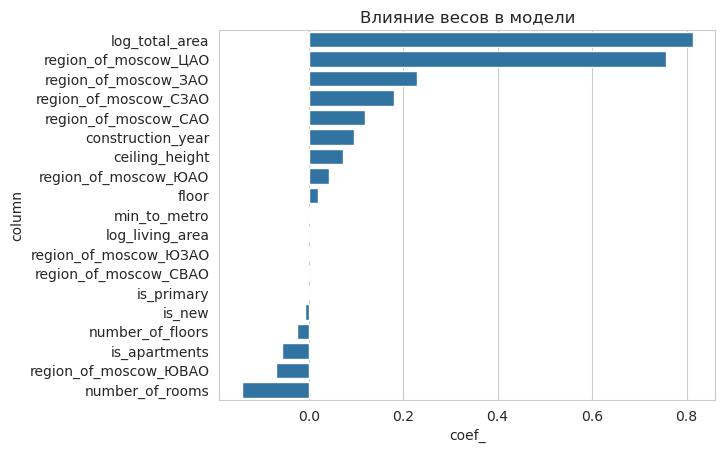

In [70]:
# Изобразим влияние каждого веса на диаграмме

sns.barplot(data = weights, x = 'coef_', y = 'column', orient = 'h')
plt.title('Влияние весов в модели')
plt.show()

#### Оценка качества модели

In [71]:
# Импортируем MAE, RMSE, R2

from sklearn.metrics import mean_absolute_error, \
                            root_mean_squared_error, \
                            mean_absolute_percentage_error, \
                            r2_score

In [72]:
# Перед оценкой переведём целевую переменную в стандартную шкалу

y_pred = np.exp(log_y_pred)
y_test = np.exp(log_y_test)

y_pred.shape, y_test.shape # для проверки

((1342,), (1342,))

In [73]:
# Выведем метрики качества

print(pd.Series({
    'MAE': mean_absolute_error(y_pred, y_test),
    'RMSE': root_mean_squared_error(y_pred, y_test),
    'MAPE': mean_absolute_percentage_error(y_pred, y_test),
    'R2': r2_score(y_pred, y_test)
}))

MAE     1.774228e+07
RMSE    3.935601e+07
MAPE    2.867246e-01
R2      5.297946e-01
dtype: float64


Коэффициент детерминации $R^2 \approx0.53$ — это крайне плохой результат. К тому же, средняя абсолютная ошибка почти что в $18$ млн вряд ли устроит заказчика. Попробуем выяснить, с чем это связано.

Для этого изобразим диаграммы ошибок для полученной модели. Подсветим квартиры, которые выбивались из границ межквартильного размаха.

In [74]:
# Изобразим диаграммы соответствия для предсказанных и реальных данных
# для обычных квартир

def plot_correspondence_diagram(
        y_test, y_pred, names, scale, 
        alphas = [1, 1, 1], hue = None
):
    """
    Отрисовывает диаграммы "предсказание - ошибка" и 
    "предсказание - реальность"
    """
    
    i = 0
    for name in ['ax0_xlabel', 'ax0_ylabel', 'ax1_xlabel', 
                 'ax1_ylabel', 'ax0_title', 'ax1_title']:
        if name not in list(names.keys()):
            print(f"Предупреждение: не хватает ключа {name} в names",
                  f"Будет выставлено значение x_{i}")
            names[name] = 'x_' + str(i)
    
    fig, axes = plt.subplots(1, 2, figsize = (14, 6))
    
    # Построим диаграмму "предсказание - ошибка" (в scale^{-1}-шкалах)
    residuals = y_test - y_pred
    sns.scatterplot(
        x = y_pred, 
        y = residuals, 
        ax = axes[0],
        alpha =  alphas[0],
        hue = hue
    )
    axes[0].axhline(0, color = 'red', alpha = alphas[2])

    # Построим диаграмму "предсказание - реальность" (в обычных шкалах)
    data = pd.DataFrame({
        'x': scale(y_pred),
        'y': scale(y_test)
    })
    
    # Добавим регрессионную прямую для наглядности
    sns.regplot(
        data = data, x = 'x', y = 'y',
        scatter_kws = {'alpha': alphas[1]},
        line_kws = {'color': 'red', 'alpha': alphas[2]},
        ax = axes[1]
    )
    
    axes[0].set_xlabel(names['ax0_xlabel'])
    axes[0].set_ylabel(names['ax0_ylabel'])
    
    axes[1].set_xlabel(names['ax1_xlabel'])
    axes[1].set_ylabel(names['ax1_ylabel'])
    
    axes[0].set_title(names['ax0_title'])
    axes[1].set_title(names['ax1_title'])
    
    plt.show()

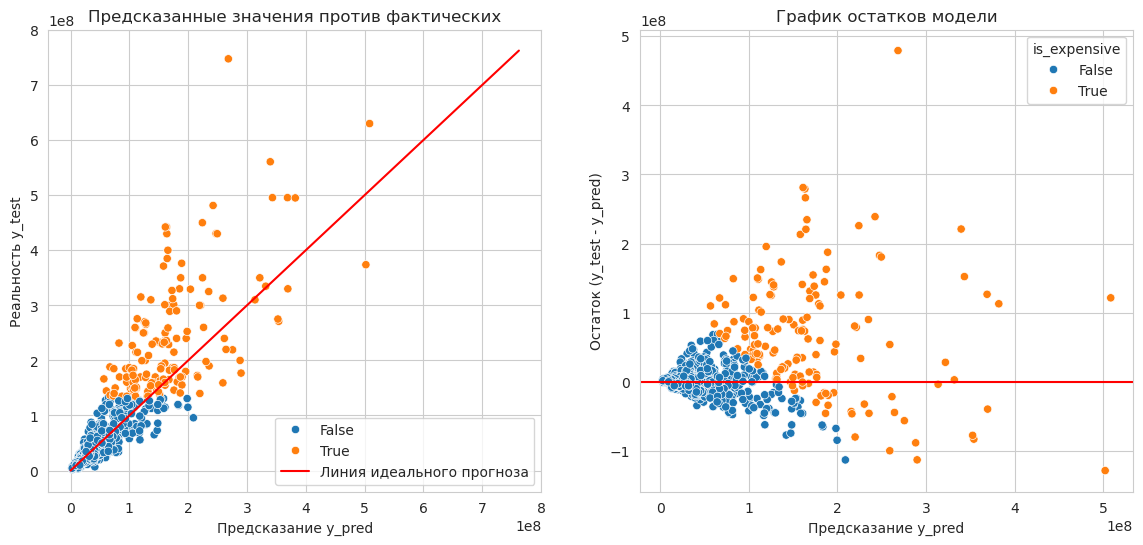

In [75]:
# Изобразим диаграммы соответствия для предсказанных и реальных данных

# Найдём границы межквартильного размаха для выделения выбросов
l, average_right_boundary, iqr = IQR(estate['price'])

y_test_results = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'remainder': y_test - y_pred,
    'is_expensive': y_test > average_right_boundary # Выделим выбросы в отдельную категорию
}, index = y_test.index)

y_equals_x = np.linspace(0, max(y_test) * 1.02)

fig, axes = plt.subplots(1, 2, figsize = (14, 6))

# Диаграмма "предсказание - реальность"
sns.scatterplot(
    data = y_test_results, 
    x = 'y_pred', 
    y = 'y_test', 
    hue = 'is_expensive', # Перекрасим выбранные значения
    ax = axes[0]
)

# Линия y = x
sns.lineplot(
    x = y_equals_x,
    y = y_equals_x,
    color = 'red',
    ax = axes[0],
    label = 'Линия идеального прогноза',
)

# Диаграмма ошибок
sns.scatterplot(
    data = y_test_results, 
    x = 'y_pred', 
    y = 'remainder', 
    hue = 'is_expensive', # Перекрасим выбранные значения
    ax = axes[1]
)

axes[0].set_title('Предсказанные значения против фактических')
axes[1].set_title('График остатков модели')

axes[0].set_xlabel('Предсказание y_pred')
axes[0].set_ylabel('Реальность y_test')

axes[1].set_xlabel('Предсказание y_pred')
axes[1].set_ylabel('Остаток (y_test - y_pred)')

plt.axhline(0, color = 'red')
plt.show()

Видим (см. правый график), что стандартное отклонение ошибок модели растёт с увеличением стоимости. Кроме того, из левого графика видно, что квартиры из стандартного ценового сегмента (соответствующие голубым точкам) сгущаются около диагонали, в то время как отклонение прогноза от реального значения наблюдается именно в элитном ценовом сегменте (рыжие точки).

На этом основании мы можем сделать предположение, что скудное качество обучения модели может быть связано с наличием большого количества сравнительно дорогих объектов недвижимости в выборке. Повысить качество обучения модели, разделим выборку на две части — условно "стандартный" сегмент, то есть недвижимость дешевле $134$ млн руб.$^1$, и элитный "сегмент", то есть недвижимость дороже указанной суммы.

<small>$^1$  $134,585,250$ руб — это правая граница межквартильного интервала</small>

In [76]:
# Правая граница межквартильного интервала

print(average_right_boundary)

134585250.0


## Разделение недвижимости на классы

In [77]:
# Выделим элитные квартиры

is_expensive = (estate['price'] > average_right_boundary)
elite_estate = estate[is_expensive]
average_estate = estate[~is_expensive]

elite_estate.price.min() > average_estate.price.max() # Проверим выборки на адекватность (необязательно)

np.True_

In [78]:
# Рассмотрим features

features

['region_of_moscow',
 'is_new',
 'is_apartments',
 'is_primary',
 'min_to_metro',
 'floor',
 'number_of_floors',
 'construction_year',
 'ceiling_height',
 'number_of_rooms',
 'log_total_area',
 'log_living_area']

In [79]:
# Реализуем ранее проведённые операции обучения моделей в виде класса LassoCV_model

# Создадим вспомогательный класс для хранения метрик качества модели
class Metrics:
    "Класс для оценки метрик модели"
    def __init__(self, y_test, y_pred):
        self.MAE = mean_absolute_error(y_test, y_pred)
        self.RMSE = root_mean_squared_error(y_test, y_pred)
        self.MAPE = mean_absolute_percentage_error(y_test, y_pred)
        self.r2_score = r2_score(y_test, y_pred)

    def display(self):
        return pd.Series({
            'MAE': self.MAE,
            'RMSE': self.RMSE,
            'MAPE': self.MAPE,
            'r2_score': self.r2_score
        })

# Класс, объект которого при инициализации будет обучать модель
# на переданной выборке и считать метрики качества
class LassoCV_model:
    def __init__(self, X, y, by, scale = lambda x: x, cv = 5):
        """
        Обучает регрессионную модель с L1-регуляризатором на выборке (X, y).

    
        Параметры:
            X     - матрица признаков
            y     - вектор ответов
            by    - столбец в матрице X, по которму выполнять стратификацию
            scale - lambda-функция, задающая шкалу, обратную к шкале вектора y

        Возвращает:
            ничего не возвращает, но в случае успеха образец класса будет
            содержать все параметры модели, а также её веса и метрики
            качества

        Доступные параметры для обученной модели:
            X_train, X_test, y_train, y_test
                          - обучающие и тестовые выборки
            lasso         - обученная модель с L1-регуляризатором
            y_pred        - предсказанный на X_train вектор
            weights_table - таблица весов в порядке убывания их значимости
            metrics       - объект класса Metrics, содержащий метрики качества 
                            модели
        """
        global categorical_features, binary_features, numeric_features
    
        self.X = X
        self.y = y
        self.by = by
        self.scale = scale
    
        # Разделим данные
        X_train_raw, X_test_raw, self.y_train, self.y_test = train_test_split(
            X, y,
            test_size = 0.2,
            random_state = 123,
            stratify = by
        )
    
    
        # Создадим трансформер
        self.transformer = ColumnTransformer(
            transformers = [
                ('numeric', StandardScaler(), numeric_features),
                ('categorical', OneHotEncoder(handle_unknown = 'ignore', drop = 'first', dtype = int), categorical_features),
                ('binary', 'passthrough', binary_features)
            ],
            verbose_feature_names_out = False
        )
    
        # Трансформируем данные
        self.X_train = self.transformer.fit_transform(X_train_raw) # обучаем трансформер на X_train и преобразуем
        self.X_test = self.transformer.transform(X_test_raw) # преобразуем X_test БЕЗ обучения
    
        # Инициализируем модель
        self.lasso = LassoCV(cv = cv)
        columns = self.transformer.get_feature_names_out() # возвращаем названия колонок
    
        # Обучим модель
        self.lasso.fit(self.X_train, self.y_train)
    
        # Предскажем значения на тестовой выборке
        self.y_pred = self.lasso.predict(self.X_test)
    
        # Сохраним веса модели
        self.weights_table = pd.DataFrame({
            'coef_': self.lasso.coef_
        }, index = columns).sort_values(by = ['coef_'], ascending = False)
        self.weights_table.index = self.weights_table.index.rename('column')
    
        # Посчитаем метрики качества
        self.metrics = Metrics(self.scale(self.y_test), self.scale(self.y_pred))

        print('Модель обучена!')

In [80]:
# Создадим обучающие выборки для разделённых данных

average_X, average_log_y = average_estate[features].copy(), average_estate[y_col]
elite_X, elite_log_y = elite_estate[features].copy(), elite_estate[y_col]

In [81]:
# Обучим модель на обычных домах

exp_scale = lambda y: np.exp(y) # Экспонента возвращает от логарифмической 
                                # шкалы к обычной

# Обучим первую модель
average_model = LassoCV_model(
    average_X, average_log_y, by = average_X['region_of_moscow'],
    scale = exp_scale
)

Модель обучена!


In [82]:
# Обучим вторую модель

# elite_lasso, elite_log_y_pred, elite_metrics = LassoCV_model(
#     elite_X, elite_log_y, by = elite_X['region_of_moscow'],
#     scale = exp_scale
# )

Данный код вызывает ошибку:

``` Python
ValueError: The least populated classes in y have only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. Classes with too few members are: ['ЮАО', 'ЮЗАО']
```

Посмотрим на указанные регионы для элитных квартир:

In [83]:
# Найдём проблемные записи

rare_regions = ['ЮАО', 'ЮЗАО']
elite_X.loc[elite_X['region_of_moscow'].isin(rare_regions)]

Название поля,region_of_moscow,is_new,is_apartments,is_primary,min_to_metro,floor,number_of_floors,construction_year,ceiling_height,number_of_rooms,log_total_area,log_living_area
6060,ЮЗАО,0,0,0,13.0,17,19,2011,3.1,4.0,5.086979,4.605170
6921,ЮАО,0,0,0,11.0,5,9,2021,3.8,4.0,4.821088,4.406719


Для того, чтобы не потерять полноту данных, заменим эти два региона на новое значение `Другое`:

In [84]:
# Добавим новую категорию

elite_X['region_of_moscow'] = elite_X['region_of_moscow'].cat.add_categories(['Другое'])

In [85]:
# Отнесём редкие записи к новой категории

elite_X.loc[elite_X['region_of_moscow'].isin(rare_regions), 'region_of_moscow'] = 'Другое'

# Уберём лишние категории, чтобы не столкнуться с мультиколлинеарностью
elite_X['region_of_moscow'] = elite_X['region_of_moscow'].cat.remove_unused_categories()

elite_X['region_of_moscow'].value_counts()

region_of_moscow
ЦАО       668
ЗАО        76
САО        23
СЗАО       12
Другое      2
Name: count, dtype: int64

In [86]:
# Обучим модель на элитных квартирах

elite_model = LassoCV_model(
    elite_X, elite_log_y, by = elite_X['region_of_moscow'],
    scale = exp_scale
)

Модель обучена!


Модели обучены!

## Проверка качества моделей

### Проверка обычного сегмента

In [87]:
# Рассмотрим метрики модели

average_model.metrics.display()

MAE         9.153162e+06
RMSE        1.503066e+07
MAPE        2.815884e-01
r2_score    7.149722e-01
dtype: float64

Коэффициент детерминации $R^2 \approx 71,5\%$, поэтому модель будет достаточно качественно описывать подавляющее большинство квартир на  рынке. Исследуем полученные веса для получения более качественных выводов.

In [88]:
# Рассмотрим веса модели для обычных квартир

average_model.weights_table

,coef_
column,
region_of_moscow_ЦАО,0.670417
log_total_area,0.594409
region_of_moscow_ЗАО,0.237193
region_of_moscow_СЗАО,0.205593
region_of_moscow_САО,0.140101
region_of_moscow_ЮАО,0.096371
construction_year,0.076907
ceiling_height,0.074515
region_of_moscow_ЮЗАО,0.060052


Добавим столбец, отражающий влияние каждого признака:

In [89]:
# Добавим столбец, отображающий влияние каждого признака

impact_col = '+1% к стоимости'

weights = average_model.weights_table.copy()
weights[impact_col] = weights['coef_']

# Достанем признаки - идентификаторы региионов
regions = [feature  for feature in new_columns if feature.startswith('region_of_moscow_')]

# Достанем логарифмы
log_features = []
for feature in numeric_features:
    if feature.startswith('log_'):
        log_features.append(feature)

# Очистим логарифмы
for log in log_features:
    if log in numeric_features:
        numeric_features.remove(log)

# Рассчитаем влияние
weights.loc[regions, impact_col] = np.exp(weights.loc[regions, 'coef_']) - 1
weights.loc[binary_features, impact_col] = np.exp(weights.loc[binary_features, 'coef_']) - 1
weights.loc[numeric_features, impact_col] = np.exp(weights.loc[numeric_features, 'coef_']) - 1
weights.loc[log_features, impact_col] = np.exp(weights.loc[log_features, 'coef_']) # не меняем

weights

,coef_,+1% к стоимости
column,,
region_of_moscow_ЦАО,0.670417,0.955053
log_total_area,0.594409,1.811960
region_of_moscow_ЗАО,0.237193,0.267685
region_of_moscow_СЗАО,0.205593,0.228254
region_of_moscow_САО,0.140101,0.150390
region_of_moscow_ЮАО,0.096371,0.101168
construction_year,0.076907,0.079942
ceiling_height,0.074515,0.077361
region_of_moscow_ЮЗАО,0.060052,0.061892


Для более приятного отражения результата преобразуем полученный столбец в проценты:

In [90]:
# Переведём вклад признаков в вид '+/- вклад%'

def determine_impact_sign(x, precision = 4):
    """
    Переводит дробь x в строку '+/- x%'
    """
    if x == 0:
        return '0'
    sign = '+' if x > 0 else '' # для x < 0 знак уже стоит
    signed_x = sign + str(round(x, precision)) + '%'
    return signed_x

weights.columns = ['Значение веса', impact_col]
weights[impact_col] = weights[impact_col].apply(determine_impact_sign)
weights

,Значение веса,+1% к стоимости
column,,
region_of_moscow_ЦАО,0.670417,+0.9551%
log_total_area,0.594409,+1.812%
region_of_moscow_ЗАО,0.237193,+0.2677%
region_of_moscow_СЗАО,0.205593,+0.2283%
region_of_moscow_САО,0.140101,+0.1504%
region_of_moscow_ЮАО,0.096371,+0.1012%
construction_year,0.076907,+0.0799%
ceiling_height,0.074515,+0.0774%
region_of_moscow_ЮЗАО,0.060052,+0.0619%


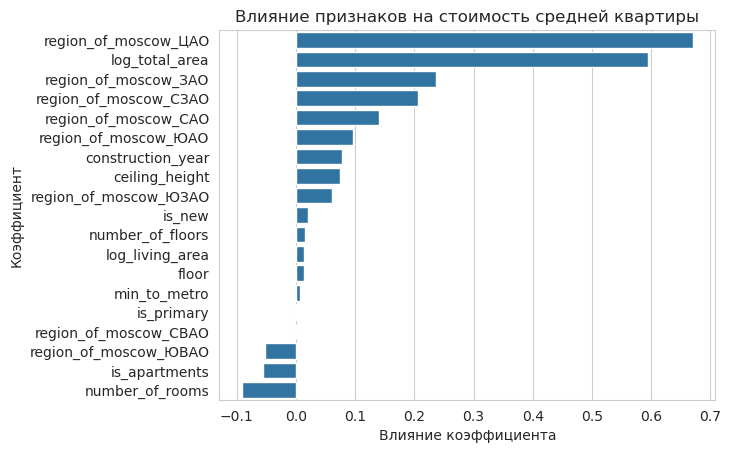

In [91]:
# Оценим влияние признаков модели для обычных квартир

sns.barplot(data = average_model.weights_table, x = 'coef_', y = 'column', orient = 'h')
plt.title('Влияние признаков на стоимость средней квартиры')
plt.xlabel('Влияние коэффициента')
plt.ylabel('Коэффициент')
plt.show()

Из этой диаграммы наиболее явно видно, что нахождение квартиры в СВАО не изменяет её стоимости и происходит исходя из характеристик самой недвижимости. Кроме того, является ли недвижимость первичным жильём или нет, также не играет роли.

Посмотрим на диаграммы соответствия для предсказанных и реальных данных для обычных квартир.

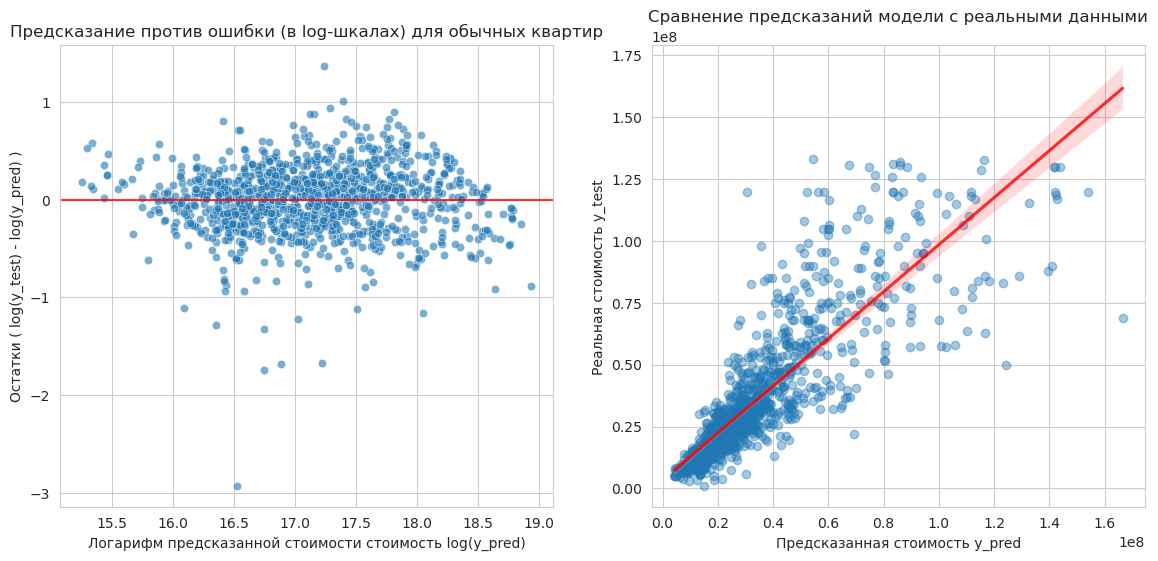

In [92]:
# Изобразим диаграммы соответствия для предсказанных и реальных данных
# для обычных квартир

names = {
    'xlabel': 'Предсказанная стоимость y_pred',
    'ylabel': 'Остатки (ошибка в log)',
    'ax0_xlabel': 'Логарифм предсказанной стоимости стоимость log(y_pred)',
    'ax0_ylabel': 'Остатки ( log(y_test) - log(y_pred) )',
    'ax1_xlabel': 'Предсказанная стоимость y_pred',
    'ax1_ylabel': 'Реальная стоимость y_test',
    'ax0_title': 'Предсказание против ошибки (в log-шкалах) для обычных квартир',
    'ax1_title': 'Сравнение предсказаний модели с реальными данными'
}

plot_correspondence_diagram(average_model.y_test,  average_model.y_pred, names, exp_scale, [0.6, 0.4, 0.8])

Левый график представляет собой диаграмму ошибок для логарифмированной целевой переменной. Мы видим, что облако точек сгущается вокруг горизонтальной прямой, проходящей на отметке $0$. Это говорит о том, что средняя относительная ошибка для данной модели постоянна и равна $28,2\%$ вне зависимости от стоимости в стандартном ценовом сегменте. Визуальная воронка на правом графике является неизбежным результатом обратного перехода от логарифмической к стандартной шкале: для более дорогой квартиры абсолютная ошибка в прогнозе будет больше, чем для сравнительно дешёвой, при этом относительная погрешность будет одинаковой. Таким образом, наша модель адекватно предсказывает стоимость жилья с постоянной относительной ошибкой в $28,2\%$ (см. выводы по данной модели ниже). 

Наконец, выведем базовый параметр для составляния формулы:

In [93]:
# Выведем базовый параметр модели для обычных квартир

print("\nbeta_0 =", average_model.lasso.intercept_)


beta_0 = 16.909336409569185


Это — базовая стоимость квартиры с "нулевыми" показателями

### Выводы по среднему сегменту

Результаты, выведенные для сегмента недвижимости дешевле $134$ млн руб, позволяют сказать, что в $\approx 71\%$ случаев модель будет давать обоснованный результат со средней абсолютной погрешностью $\approx 9,1$ млн рублей и относительной погрешностью в $28,2\%$.

Признаки, которые больше всего *положительно* влияют на ценообразование рынка недвижимости:
* `регион — ЦАО`. Наличие этого признака увеличивает стоимость в $\approx 1.57$ раз, то есть на $57\%$;
* `общая площадь` квартиры. Увеличение площади на $1\%$ увеличит стоимость недвижимости на $0.59\%$;
* `регион — ЗАО`. Аналогично. Квартиры в этом районе становятся дороже примерно на $26\%$.

Среди тех признаков, что *негативно* влияют на стоимость квартир, укажем наиболее значимые:
* `количество комнат`. При увеличении количества комнат при той же площади стоимость падает примерно на $8.76\%$. Это означает, что покупатели больше ценят просторные квартиры с меньшим количеством комнат;
* `недвижимость — апартамент`. Иметь апартаменты невыгодно: у квартиры с такими же показателями (включая местоположение), что и рассматриваемые апартаменты, стоимость будет выше на $5.4\%$;
* `регион — ЮВАО`. Квартиры в этом регионе дешевле на $5.1%$ аналогичных квартир в других районах.

Также имеется *нейтральный* признак:
* `регион — СВАО`. Стоимость квартиры, как правило, рассчитывается только исходя из параметров

Вклад каждого признака можно получить из следующей таблицы:

In [94]:
pd.DataFrame(weights[impact_col])

,+1% к стоимости
column,
region_of_moscow_ЦАО,+0.9551%
log_total_area,+1.812%
region_of_moscow_ЗАО,+0.2677%
region_of_moscow_СЗАО,+0.2283%
region_of_moscow_САО,+0.1504%
region_of_moscow_ЮАО,+0.1012%
construction_year,+0.0799%
ceiling_height,+0.0774%
region_of_moscow_ЮЗАО,+0.0619%


Итоговая формула для расчёта стоимости квартиры из среднего сегмента имеет следующий вид:
$$
\text{Стоимость} = 
\begin{pmatrix} \text{Влияние} \\ \text{района} \end{pmatrix} \cdot
\begin{pmatrix} \text{Характеристики} \\ \text{дома} \end{pmatrix} \cdot
\begin{pmatrix} \text{Характеристики} \\ \text{квартиры} \end{pmatrix} \cdot
\begin{pmatrix} \text{Влияние} \\ \text{площади} \end{pmatrix}.
$$

Множитель $(\text{Влияние района})$ рассчитывается по следующей формуле:
$$
\begin{aligned}
\begin{pmatrix} \text{Влияние} \\ \text{района} \end{pmatrix}
& = \exp \bigl( 0.67 \cdot \text{ЦАО} + 0.24 \cdot \text{ЗАО} + 0.21 \cdot \text{СЗАО} + 0.14 \cdot \text{САО} \\ 
& + 0.10 \cdot \text{ЮАО} + 0.06 \cdot \text{ЮЗАО} - 0.05 \cdot \text{ЮВАО} \bigr),
\end{aligned}
$$
где лишь одно название района принимает значение $1$ (в этом районе располагается квартира), а остальные — $0$.

Множитель $(\text{Характеристики дома})$ вычисляются так:
$$
\begin{aligned}
\begin{pmatrix} \text{Характеристики} \\ \text{дома} \end{pmatrix}
& = \exp \bigl( 0.02 \cdot \text{(Новостройка)} + 0.08 \cdot \text{(Год постройки)} \\
& + 0.02 \cdot \text{(Этажность дома)} + 0.01 \cdot \text{(Минут до метро)} \bigr),
\end{aligned}
$$
где $(\text{Новостройка})$ принимает значение $0$ или $1$ в зависимости от наличия соответствующего фактора.


$$
\begin{aligned}
\begin{pmatrix} \text{Характеристики} \\ \text{квартиры} \end{pmatrix}
& = \exp \bigl( -0.06 \cdot \text{(Апартаменты)}+ 0.01 \cdot \text{(Этаж)} \\
& - 0.09 \cdot \text{(Кол-во комнат)} + 0.07 \cdot \text{(Высота потолков)} \bigr),
\end{aligned}
$$
где $(\text{Апартаменты})$ принимает значение $0$ или $1$ в зависимости от наличия соответствующего фактора. 

*Примечание* фактор $(\text{Первичное жильё})$, сконструированный перед обучением модели, не оказывает влияние на формулу.

$$
\begin{aligned}
\begin{pmatrix} \text{Влияние} \\ \text{площади} \end{pmatrix}
& = \bigl( \text{Площадь}_{\text{общая}} \bigr) ^{0.59} \cdot \bigl( \text{Площадь}_{\text{жилая}} \bigr) ^{0.01}
\end{aligned}
$$

В развёрнутом виде указанная стоимость примет вид
$$
\begin{aligned}
\text{Стоимость} = \exp \Bigl( &0.67 \cdot \text{ЦАО} + 0.24 \cdot \text{ЗАО} + 0.21 \cdot \text{СЗАО} + 0.14 \cdot \text{САО} + 0.10 \cdot \text{ЮАО} + 0.06 \cdot \text{ЮЗАО} - 0.05 \cdot \text{ЮВАО} \\
& + 0.02 \cdot \text{(Новостройка)} - 0.06 \cdot \text{(Апартаменты)} + 0.00 \cdot \text{(Первичка)} \\
& + 0.08 \cdot \text{(Год)} + 0.02 \cdot \text{(Этажность)} + 0.01 \cdot \text{(Этаж)} - 0.09 \cdot \text{(Комнаты)} \\
& + 0.59 \cdot \ln(\text{Площадь}_{\text{общая}}) + 0.01 \cdot \ln(\text{Площадь}_{\text{жилая}}) + 0.07 \cdot \text{(Потолки)} + 0.01 \cdot \text{(Метро)} + 16.91 \Bigr)
\end{aligned}
$$

### Проверка элитного сегмента

In [95]:
# Рассмотрим метрики каччества модели для элитных квартир

elite_model.metrics.display()

MAE         5.984062e+07
RMSE        8.486677e+07
MAPE        2.431401e-01
r2_score    3.598973e-01
dtype: float64

Коэффициент детерминации $R^2 \approx 36\%$, но даже для такого процента квартир средняя абсолютная ошибка в определении стоимости будет в среднем составлять $MAE \approx 60$ млн руб. Данная модель крайне плохо описывает реальное состояние рынка. Несмотря на то что средняя относительная $MAPE \approx 24,3\%$ у неё ниже, чем у предыдущей модели, на её результаты опираться нельзя. 

Удостовериться в неадекватности модели можно и графически, что мы и сделаем:

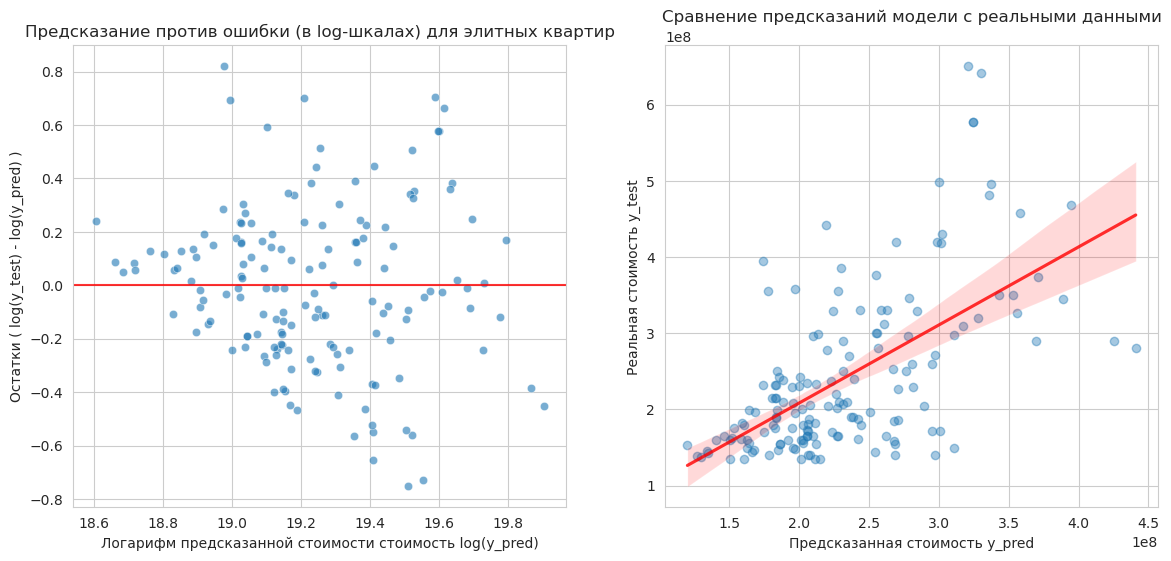

In [96]:
# Проверим качество модели для элитных квартир графически

names['ax0_title'] = 'Предсказание против ошибки (в log-шкалах) для элитных квартир'

plot_correspondence_diagram(elite_model.y_test,  elite_model.y_pred, names, exp_scale, [0.6, 0.4, 0.8])

Мы можем наблюдать явно выраженную гетероскедастичность данных как в стандартных, так и в логарифмических шкалах: разброс ошибок в логарифмической шкале растёт пропорционально стоимости. Такая модель не будет предсказывать обоснованную рыночную стоимость. Связано это с тем, что на стоимость недвижимости в данном ценовом сегменте вляют не только указанные выше характеристики жилья, но и прочие, в том числе, нелинейные зависимости: ими могут быть наличие парковок, наличие консьерж-сервиса и пр.

### Выводы по элитному сегменту

Полученная для недвижимости в элитном ценовом сегменте модель, хоть и имеет среднюю относительную ошибку $MAPE \approx 24,3\%$, что ниже чем у предыдущей модели, — но имеет крайне низкий коэффициент детерминации $R^2 \approx 36\%$, что говорит, в первую очередь о том, что на стоимость недвижимости дорогих квартир в Москве влияют не только те характеристики, что были предоставлены для анализа в этой работе, но и другие. Таковые могут включать наличие спектра предоставляемых сервисов и услуг, архитектурных особенностей и прочего. Для получения информации о стоимости такой недвижимости требуется либо сбор дополнительных данных, либо личная экспертная оценка.

## Итоговый вывод

В ходе выполнения проекта была предпринята попытка обучить линейную модель при помощи технологии линейной регрессии с $L_1$-регуляризатором. Выбор данной модели объясняется её интерпретируемостью и способностью отбирать признаки, существенно влияющие на образование стоимости недвижимости.

После обучения было обнаружена гетероскедастичность данных, говорящая о том, что полученная модель не будет давать обоснованной стоимости недвижимости, и на её нельзя использовать на практике. Тем не менее, было обнаружено, что в ценовом сегменте "дешевле $134$ млн руб." модель смогла уловить закономерности сравнительно лучше, чем для более дорогих объектов недвижимости. В связи с чем было предложено условно разделить недвижимость на "стандартную" (дешевле $134$ млн руб.) и "элитную"(соответственно дороже $134$ млн руб.), а затем по отдельности обучить две модели на данных подвыборках.

После обучения обеих моделей были получены следующие результаты:

#### Вывод по недвижимости дешевле 134 млн руб.

Результаты, выведенные для недвижимости в ценовом сегменте "дешевле $134$ млн руб.", показывают, что в $\approx 71\%$ случаев модель будет давать обоснованный результат со средней абсолютной погрешностью $\approx 9,1$ млн рублей и относительной погрешностью в $28,2\%$.  На такую модель можно полагаться, поскольку она адекватно описывает практически $\frac{3}{4}$ всего московского рынка в данном ценовом сегменте.

Для уменьшения относительной ошибки рекомендуется проведение сбора дополнительных данных, характеризующих объекты недвижимости.

Признаки, которые больше всего *положительно* влияют на ценообразование рынка недвижимости:
* `регион — ЦАО`. Наличие этого признака увеличивает стоимость в $\approx 1.57$ раз, то есть на $57\%$;
* `общая площадь` квартиры. Увеличение площади на $1\%$ увеличит стоимость недвижимости на $0.59\%$;
* `регион — ЗАО`. Аналогично. Квартиры в этом районе становятся дороже примерно на $26\%$.

Среди тех признаков, что *негативно* влияют на стоимость квартир, укажем наиболее значимые:
* `количество комнат`. При увеличении количества комнат при той же площади стоимость падает примерно на $8.76\%$. Это означает, что покупатели больше ценят просторные квартиры с меньшим количеством комнат;
* `недвижимость — апартамент`. Иметь апартаменты невыгодно: у квартиры с такими же показателями (включая местоположение), что и рассматриваемые апартаменты, стоимость будет выше на $5.4\%$;
* `регион — ЮВАО`. Квартиры в этом регионе дешевле на $5.1%$ аналогичных квартир в других районах.

Также имеется *нейтральный* признак:
* `регион — СВАО`. Стоимость квартиры, как правило, рассчитывается только исходя из параметров

Вклад каждого признака можно получить из следующей таблицы:

In [97]:
pd.DataFrame(weights[impact_col])

,+1% к стоимости
column,
region_of_moscow_ЦАО,+0.9551%
log_total_area,+1.812%
region_of_moscow_ЗАО,+0.2677%
region_of_moscow_СЗАО,+0.2283%
region_of_moscow_САО,+0.1504%
region_of_moscow_ЮАО,+0.1012%
construction_year,+0.0799%
ceiling_height,+0.0774%
region_of_moscow_ЮЗАО,+0.0619%


Итоговая формула для расчёта стоимости квартиры из среднего сегмента имеет следующий вид:
$$
\text{Стоимость} = 
\begin{pmatrix} \text{Влияние} \\ \text{района} \end{pmatrix} \cdot
\begin{pmatrix} \text{Характеристики} \\ \text{дома} \end{pmatrix} \cdot
\begin{pmatrix} \text{Характеристики} \\ \text{квартиры} \end{pmatrix} \cdot
\begin{pmatrix} \text{Влияние} \\ \text{площади} \end{pmatrix}.
$$

Множитель $(\text{Влияние района})$ рассчитывается по следующей формуле:
$$
\begin{aligned}
\begin{pmatrix} \text{Влияние} \\ \text{района} \end{pmatrix}
& = \exp \bigl( 0.67 \cdot \text{ЦАО} + 0.24 \cdot \text{ЗАО} + 0.21 \cdot \text{СЗАО} + 0.14 \cdot \text{САО} \\ 
& + 0.10 \cdot \text{ЮАО} + 0.06 \cdot \text{ЮЗАО} - 0.05 \cdot \text{ЮВАО} \bigr),
\end{aligned}
$$
где лишь одно название района принимает значение $1$ (в этом районе располагается квартира), а остальные — $0$.

Множитель $(\text{Характеристики дома})$ вычисляются так:
$$
\begin{aligned}
\begin{pmatrix} \text{Характеристики} \\ \text{дома} \end{pmatrix}
& = \exp \bigl( 0.02 \cdot \text{(Новостройка)} + 0.08 \cdot \text{(Год постройки)} \\
& + 0.02 \cdot \text{(Этажность дома)} + 0.01 \cdot \text{(Минут до метро)} \bigr),
\end{aligned}
$$
где $(\text{Новостройка})$ принимает значение $0$ или $1$ в зависимости от наличия соответствующего фактора.


$$
\begin{aligned}
\begin{pmatrix} \text{Характеристики} \\ \text{квартиры} \end{pmatrix}
& = \exp \bigl( -0.06 \cdot \text{(Апартаменты)}+ 0.01 \cdot \text{(Этаж)} \\
& - 0.09 \cdot \text{(Кол-во комнат)} + 0.07 \cdot \text{(Высота потолков)} \bigr),
\end{aligned}
$$
где $(\text{Апартаменты})$ принимает значение $0$ или $1$ в зависимости от наличия соответствующего фактора. 

*Примечание* фактор $(\text{Первичное жильё})$, сконструированный перед обучением модели, не оказывает влияние на формулу.

$$
\begin{aligned}
\begin{pmatrix} \text{Влияние} \\ \text{площади} \end{pmatrix}
& = \bigl( \text{Площадь}_{\text{общая}} \bigr) ^{0.59} \cdot \bigl( \text{Площадь}_{\text{жилая}} \bigr) ^{0.01}
\end{aligned}
$$

В развёрнутом виде указанная стоимость примет вид
$$
\begin{aligned}
\text{Стоимость} = \exp \Bigl( &0.67 \cdot \text{ЦАО} + 0.24 \cdot \text{ЗАО} + 0.21 \cdot \text{СЗАО} + 0.14 \cdot \text{САО} + 0.10 \cdot \text{ЮАО} + 0.06 \cdot \text{ЮЗАО} - 0.05 \cdot \text{ЮВАО} \\
& + 0.02 \cdot \text{(Новостройка)} - 0.06 \cdot \text{(Апартаменты)} + 0.00 \cdot \text{(Первичка)} \\
& + 0.08 \cdot \text{(Год)} + 0.02 \cdot \text{(Этажность)} + 0.01 \cdot \text{(Этаж)} - 0.09 \cdot \text{(Комнаты)} \\
& + 0.59 \cdot \ln(\text{Площадь}_{\text{общая}}) + 0.01 \cdot \ln(\text{Площадь}_{\text{жилая}}) + 0.07 \cdot \text{(Потолки)} + 0.01 \cdot \text{(Метро)} + 16.91 \Bigr)
\end{aligned}
$$

#### Вывод по недвижимости дороже 134 млн руб.

Полученная для недвижимости в элитном ценовом сегменте модель, хоть и имеет среднюю относительную ошибку $MAPE \approx 24,3\%$, что ниже чем у предыдущей модели, — но имеет крайне низкий коэффициент детерминации $R^2 \approx 36\%$, что говорит, в первую очередь о том, что на стоимость недвижимости дорогих квартир в Москве влияют не только те характеристики, что были предоставлены для анализа в этой работе, но и другие. Таковые могут включать наличие спектра предоставляемых сервисов и услуг, архитектурных особенностей и прочего. Для получения информации о стоимости такой недвижимости требуется либо сбор дополнительных данных, либо личная экспертная оценка.